In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt

In [2]:
# define potential for training data
def v(x, choice=0):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # symmetric double well potential
        return 0.0025 * (x ** 2 - 25) ** 2
    elif choice == 2:
        # asymmetric double well potential
        return 0.0003 * ((x - 3) ** 4 + 10 * (x - 5) ** 3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x ** 2 + 0.25)
    else:
        print('Function v(x, choice=0): Did not recognise your input for choice.')

In [3]:
# set L of spatial domain
L = 15
# create vector of real space points for plotting
nx = 1024
xvec = np.linspace(-L, L, nx)

In [4]:
# set highest value for index of Gaussian basis
J = 100
# make vector of j values
xjvec, testh = np.linspace(-L, L, 2 * J + 1, retstep=True)
# check if jvec = n = 2 J + 1
print(f'Size xjvec: {len(xjvec)}, n: {2 * J + 1}')
# check if first value of xjvec = -L and last value = L
print(f'L: {L}, First val xjvec: {xjvec[0]}, Last val xjvec: {xjvec[-1]}')
# check if true h and returned step value agree
print(f'L / J: {L / J}, step size: {testh}')

Size xjvec: 201, n: 201
L: 15, First val xjvec: -15.0, Last val xjvec: 15.0
L / J: 0.15, step size: 0.15


In [5]:
# define Gaussian basis function
def gb(x, jh, alpha):
    return np.exp(-alpha * (x - jh) ** 2)

# set fixed alpha
fixedalpha = 4.0 * np.log(2) / testh ** 2  # 60.0

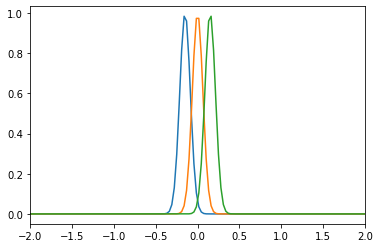

In [6]:
for thisj in range(-1, 2):
    plt.plot(xvec, gb(xvec, thisj*testh, fixedalpha))

plt.xlim(-2, 2)
plt.show()

In [7]:
# make matrix of x values on the j grid
xjmat = np.broadcast_to(xjvec, (len(xjvec), len(xjvec)))
# show what the first element of xjmat looks like
print(xjmat[0])
# show what the first element of xjmat.T looks like
print(xjmat.T[0])
# make Gaussian basis matrix.
# We want gbmat @ gbcfs = vtrue, so each row in gbmat is
# all the Gaussian basis for one value of x
gbmat = gb(xjmat.T, xjmat, fixedalpha)
# check shape of gbmat, should be (n x n)
print(f'n: {2 * J + 1}, gbmat dim: {gbmat.shape}')

[-15.   -14.85 -14.7  -14.55 -14.4  -14.25 -14.1  -13.95 -13.8  -13.65
 -13.5  -13.35 -13.2  -13.05 -12.9  -12.75 -12.6  -12.45 -12.3  -12.15
 -12.   -11.85 -11.7  -11.55 -11.4  -11.25 -11.1  -10.95 -10.8  -10.65
 -10.5  -10.35 -10.2  -10.05  -9.9   -9.75  -9.6   -9.45  -9.3   -9.15
  -9.    -8.85  -8.7   -8.55  -8.4   -8.25  -8.1   -7.95  -7.8   -7.65
  -7.5   -7.35  -7.2   -7.05  -6.9   -6.75  -6.6   -6.45  -6.3   -6.15
  -6.    -5.85  -5.7   -5.55  -5.4   -5.25  -5.1   -4.95  -4.8   -4.65
  -4.5   -4.35  -4.2   -4.05  -3.9   -3.75  -3.6   -3.45  -3.3   -3.15
  -3.    -2.85  -2.7   -2.55  -2.4   -2.25  -2.1   -1.95  -1.8   -1.65
  -1.5   -1.35  -1.2   -1.05  -0.9   -0.75  -0.6   -0.45  -0.3   -0.15
   0.     0.15   0.3    0.45   0.6    0.75   0.9    1.05   1.2    1.35
   1.5    1.65   1.8    1.95   2.1    2.25   2.4    2.55   2.7    2.85
   3.     3.15   3.3    3.45   3.6    3.75   3.9    4.05   4.2    4.35
   4.5    4.65   4.8    4.95   5.1    5.25   5.4    5.55   5.7    5.85
   6. 

In [8]:
# compute true potential
vchoice = 1
vtruexjvec = v(x=xjvec, choice=vchoice)
# check that vtruexjvec has the same dim as n
print(f'n: {2 * J + 1}, vtruexjvec dim: {len(vtruexjvec)}')
# compute the Gaussian basis coefficients using numpy.linalg.solve
vgbcoefsol = nl.solve(gbmat, vtruexjvec)
# compute the Gaussian basis coefficients using numpy.linalg.inv
vgbcoefinv = nl.inv(gbmat) @ vtruexjvec
# print norm of difference between solutions
print(f'Norm diff sol methods: {nl.norm(vgbcoefsol - vgbcoefinv)}')

n: 201, vtruexjvec dim: 201
Norm diff sol methods: 8.879615701004165e-14


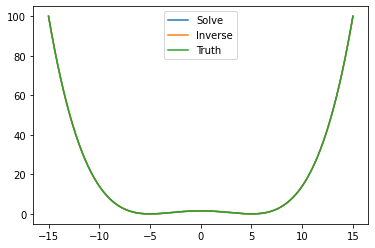

Norm diff sol: 5.691730805410122e-14
Norm diff inv: 8.625944682729244e-14


In [9]:
# reconstruct potential from Gaussian basis coefficients
vsol = gbmat @ vgbcoefsol
vinv = gbmat @ vgbcoefinv
# plot the true potential vs reconstruction of both solutions
plt.plot(xjvec, vsol, label='Solve')
plt.plot(xjvec, vinv, label='Inverse')
plt.plot(xjvec, vtruexjvec, label='Truth')
plt.legend()
plt.show()
# compute L2 error for both solution methods
print(f'Norm diff sol: {nl.norm(vtruexjvec - vsol)}')
print(f'Norm diff inv: {nl.norm(vtruexjvec - vinv)}')

In [13]:
# function for computing the L2 error given some number of basis
def error(thisvchoice = 1, thisfixedalpha = 1, thisJ = 100, thisL = 15):
    # make vector of j values
    thisxjvec, thish = np.linspace(-thisL, thisL, 2 * thisJ + 1, retstep=True)
    # make matrix of x values on the j grid
    thisxjmat = np.broadcast_to(thisxjvec, (len(thisxjvec), len(thisxjvec)))
    # compute the true potential using thisxjvec values
    thisvtruexjvec = v(x=thisxjvec, choice=thisvchoice)
    # make Gaussian basis matrix.
    # We want gbmat @ gbcfs = vtrue, so each row in gbmat is
    # all the Gaussian basis for one value of x
    thisgbmat = gb(thisxjmat.T, thisxjmat, thisfixedalpha)
    # compute the Gaussian basis coefficients using numpy.linalg.solve
    thisvgbcoefsol = nl.solve(thisgbmat, thisvtruexjvec)
    # compute the Gaussian basis coefficients using numpy.linalg.inv
    thisvgbcoefinv = nl.inv(thisgbmat) @ thisvtruexjvec
    # reconstruct potential from Gaussian basis coefficients
    thisvsol = thisgbmat @ thisvgbcoefsol
    thisvinv = thisgbmat @ thisvgbcoefinv
    # return L2 error for both solution methods
    return [nl.norm(thisvtruexjvec - thisvsol), nl.norm(thisvtruexjvec - thisvinv), thish]

In [14]:
# check that error function produces same results as above
print(error(thisvchoice = 1, thisfixedalpha = 4.0 * np.log(2) / testh ** 2, thisJ = 100, thisL = 15))

[5.691730805410122e-14, 8.625944682729244e-14, 0.15]


In [15]:
# set number of results
numres = 10

# initialize array for storing results
errorvec = []

# loop for investigating order of accuracy
# error as a function of h
# for loop sets the number of Gaussian basis
for i in np.arange(numres):
    forJ = 2**(3 + i)
    print(f'Computing Result {i+1} of {numres}')
    thiserror = error(thisvchoice = 1, thisfixedalpha = 1, thisJ = forJ, thisL = 15)
    # print(thiserror)
    errorvec.append(thiserror)

errorvec = np.array(errorvec)
print(errorvec.shape)

Computing Result 1 of 10
Computing Result 2 of 10
Computing Result 3 of 10
Computing Result 4 of 10
Computing Result 5 of 10
Computing Result 6 of 10
Computing Result 7 of 10
Computing Result 8 of 10
Computing Result 9 of 10
Computing Result 10 of 10
(10, 3)


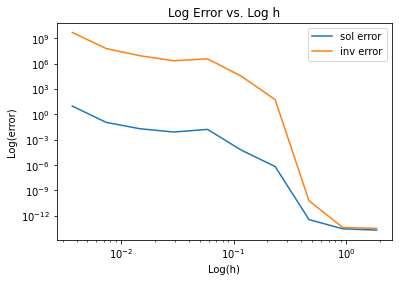

In [16]:
plt.loglog(errorvec[:,-1], errorvec[:,0], label='sol error')
plt.loglog(errorvec[:,-1], errorvec[:,1], label='inv error')
plt.title('Log Error vs. Log h')
plt.xlabel('Log(h)')
plt.ylabel('Log(error)')
plt.legend()
plt.show()
#plt.savefig('./order-of-accuracy-results/error-vs-h-plot.pdf')